1. Name - Humera Bano
2. Github Username - humera811
3. USC ID - 7255691039

In [698]:

# organizing all imports together

import pandas as pd
import os
import glob
import numpy as np
import re
import math
import csv as csv
from os.path import join, getsize
from pathlib import Path
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from turtle import right
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc



## __Time Series Classification__
Part 1: Feature Creation/Extraction
An interesting task in machine learning is classification of time series. In this problem,
we will classify the activities of humans based on time series obtained by a Wireless
Sensor Network.

#### __(a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/ Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\ %29 . The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity.1 Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.__

In [699]:
# removing extra comma in cycling dataset9.csv and cycling dataset14.csv manually as suggested on piazza
# bending2 dataset4.csv space separated (delimitter/sep_)
# https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/
path = "../../data/AReM/"
actv_dir = ['bending1', 'bending2']
actv_dir2 = ['bending1','bending2','cycling', 'lying', 'sitting', 'standing', 'walking']
features = ['mean_', 'std_', 'min_', 'first_quartile_', 'median_', 'third_quartile_','max_']
columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']


#### __(b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.__

In [700]:

# https://stackoverflow.com/questions/22809061/read-space-separated-data-with-pandas
# https://www.summet.com/dmsi/html/CSVdataFiles.html
# https://pandas.pydata.org/pandas-docs/version/0.25.0/reference/api/pandas.DataFrame.T.html
# https://docs.python.org/3/library/os.html
# https://www.tutorialspoint.com/python/os_walk.htm
# https://www.geeksforgeeks.org/python-os-path-splitext-method/

# !/usr/bin/python
def train_or_test(root):
    train_data = []
    test_set = []
    # scanning bottom-to-up
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            # Split the path in root and ext pair
            root_ext = os.path.splitext(name)  
            # checking the extension 
            root_val = root_ext[1]
            if (root_val.endswith('.csv')):
                # https://www.geeksforgeeks.org/python-regex-re-search-vs-re-findall/
                file_path = os.path.join(root, name)
                # print(file_path)
                my_path = os.path.split(root)
                feature_act = my_path[-1] #to get just the activity name
                # my_path = Path(path)
                # activity = my_path.stem
                regex = '\d+'
                match = re.findall(regex, name)
                # for bending 1 and 2 and dataset 1,2 and 3
                match_activity = int(match[0])
                bool1 = match_activity <= 2 
                bool2 = match_activity == 3 and feature_act not in actv_dir
                if (bool1 or bool2):
                    test_set.append(file_path)
                else:
                    train_data.append(file_path)
                
    return train_data, test_set
train_data, test_set = train_or_test(path)

### __(c) Feature Extraction Classification of time series usually needs extracting features from them.In this problem, we focus on time-domain features__


#### __i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc)__

Time-domain features are usually used in time series classification are:
1. Means
2. Standard Deviations
3. Skewness, Kurtosis
4. Maximum and minimum values

#### __ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance.You are free to normalize/standardize features or use them directly__

In [701]:
feature_names = ['min_','max_','mean_','median_','std_','first_quartile_','third_quartile_']
features = [name+str(i) for i in range(1,7) for name in feature_names]
# features.append('activity')
column_names = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

In [702]:
# https://stackoverflow.com/questions/18366797/pandas-read-csv-how-to-skip-comment-lines
# https://stackoverflow.com/questions/25440008/python-pandas-flatten-a-dataframe-to-a-list

csv_files = glob.glob('../../data/AReM/*/*.csv', recursive=True)
# print(csv_files)
sniffer = csv.Sniffer()

def load_data(csv_files, activity, columns,split =1, standardize=False):
    column_names = [ft + str(i) for i in range(1, 6 * split + 1) for ft in features]
    train_test_instances  = [] 
    train_test_labels = []
    # split=1
    for csv in csv_files:
        root = os.path.dirname(csv)
        my_path = os.path.split(root)
        feature_act = my_path[-1]
        # print(feature_act)
        train_test_labels.append(feature_act)
        #separator
        # https://stackoverflow.com/questions/45732459/retrieve-delimiter-infered-by-read-csv-in-pandas
        sep_ = sniffer.sniff(open(csv).read())
        sep = sep_.delimiter
        # using separator and skipping the lines that are commented
        if sep == ' ':
            df = pd.read_csv(csv, comment = '#', header=None, sep="\s+") 
        else:
            df = pd.read_csv(csv, comment = '#', header=None)
            
        df.columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
        # finding length of each split
        split_length = int(df.shape[0]/split)
        train_test_seg = []
        for j in range(split):
            df_describe = df[j*split_length : min((j+1)*split_length,df.shape[0])]
            df_describe = df_describe.describe().drop('count').drop(columns="# Columns: time").T
            train_test_seg.append(df_describe.to_numpy().flatten())
        train_test_instances.append(np.concatenate(train_test_seg, axis=None))      
    df_new = pd.DataFrame(train_test_instances, columns=column_names)
    # Set for an entire column
    df_new = df_new.loc[:, activity]
    if standardize:
        df_new = df_new.apply(lambda col: (col-col.mean()) / (np.std(col) + 1e-9), axis = 0)
    
    df_new['label'] = pd.Series(train_test_labels) # adding label as suggested on piazza
    return df_new

In [703]:
new_columns = ['min_','max_','mean_','median_','std_','first_quartile_', 'third_quartile_']
activity = [stat + str(i) for i in range(1, 7) for stat in new_columns]
#trainset
train_stats = load_data(train_data, activity, columns)
# train_data.insert(loc=0, column='row_num', value=np.arange(len(train_stats)))
# train_stats.isnull().any()
print('')
print('Train set is: ')
print(train_stats)
print('')
print('Test set is: ')
test_stats = load_data(test_set, activity, columns)
# test_stats.isnull().any()
print(test_stats)


ValueError: 258 columns passed, passed data had 42 columns

### __1. (c). iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.__

In [ ]:
#  all data set
data_set = train_stats.append(test_stats, ignore_index=True)
print('Std:')
data_set.describe().loc['std']

Std:


/var/folders/2w/fxcxhm2n4cj5sn4x1nv3vhqc0000gn/T/ipykernel_37266/2351396840.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_set = train_stats.append(test_stats, ignore_index=True)


min_1               9.569975
max_1               4.394362
mean_1              5.335718
median_1            5.440054
std_1               1.772153
first_quartile_1    6.153590
third_quartile_1    5.138925
min_2               0.000000
max_2               5.062729
mean_2              1.574164
median_2            1.412244
std_2               0.884105
first_quartile_2    0.946386
third_quartile_2    2.125266
min_3               2.956462
max_3               4.875137
mean_3              4.008380
median_3            4.036396
std_3               0.946710
first_quartile_3    4.220658
third_quartile_3    4.171628
min_4               0.000000
max_4               2.183625
mean_4              1.166114
median_4            1.145586
std_4               0.458242
first_quartile_4    0.843620
third_quartile_4    1.552504
min_5               6.124001
max_5               5.741238
mean_5              5.675593
median_5            5.813782
std_5               1.024898
first_quartile_5    6.096465
third_quartile

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html#sklearn.utils.resample
bci_estimate = pd.DataFrame(columns=["Features","90% Bootsrap confidence interval"])
count=0
new_data = train_stats.columns[:-1]
for col_name in new_data:
    estimate = []
    feature = data_set[col_name].to_numpy()
    # 1000 bootstrap samples
    for i in range(1000):
        resamples = resample(feature, replace=True, n_samples=feature.shape[0])
        estimate.append(np.std(resamples))
    lower = np.percentile(estimate,5)
    upper = np.percentile(estimate,95)
    bci_estimate.loc[count]=[col_name,'('+str(lower)+","+str(upper)+')']
    count+=1
print('')
print('BCI for std of each feature: ')
print(bci_estimate)


BCI for std of each feature: 
            Features          90% Bootsrap confidence interval
0              min_1    (8.185593344212649,10.674420722303227)
1              max_1    (3.3205212745867025,5.273250978035394)
2             mean_1    (4.690895977068329,5.8734925510661915)
3           median_1     (4.730095206589447,5.983868619190484)
4              std_1    (1.563035764682087,1.9479625186499525)
5   first_quartile_1     (5.535258321277035,6.628692792292441)
6   third_quartile_1     (4.330380706169932,5.817147908567213)
7              min_2                                 (0.0,0.0)
8              max_2     (4.613091693436644,5.372598283577017)
9             mean_2     (1.3820272873171666,1.69591576148975)
10          median_2   (1.2262189854641519,1.5352062103799184)
11             std_2   (0.8065036532256803,0.9404532279630686)
12  first_quartile_2    (0.8200801205639582,1.031325915977491)
13  third_quartile_2    (1.8691062520797972,2.274229976260767)
14             min_3   (

### __iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max)__

In [ ]:
# as suggested on piazza @587 providing reasoning by using plots
bend_train = pd.DataFrame(train_stats)
bend_train.loc[bend_train['label'].isin(actv_dir), 'label'] =1 
new_dir = ['cycling', 'lying', 'sitting', 'standing', 'walking']
bend_train.loc[bend_train['label'].isin(new_dir), 'label'] = 0
bend_train

,min_1,max_1,mean_1,median_1,std_1,first_quartile_1,third_quartile_1,min_2,max_2,mean_2,...,first_quartile_5,third_quartile_5,min_6,max_6,mean_6,median_6,std_6,first_quartile_6,third_quartile_6,label
0,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487826,0.0000,0.8300,1
1,37.00,48.00,43.454958,43.25,1.386098,42.5000,45.00,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.8700,1
2,33.00,47.75,42.179812,43.50,3.670666,39.1500,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000,1
3,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000,1
4,35.00,47.40,43.954500,44.33,1.558835,43.0000,45.00,0.0,1.70,0.426250,...,35.3625,36.5000,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.9400,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,18.50,44.25,35.752354,36.00,4.614802,33.0000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.0600,0
65,24.25,45.00,37.177042,36.25,3.581301,34.5000,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.9000,0
66,23.33,43.50,36.244083,36.75,3.822016,33.4575,39.25,0.0,9.71,2.736021,...,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.963685,2.1700,4.6175,0
67,26.25,44.25,36.957458,36.29,3.434863,34.5000,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.0300,0


Different features analysis: 


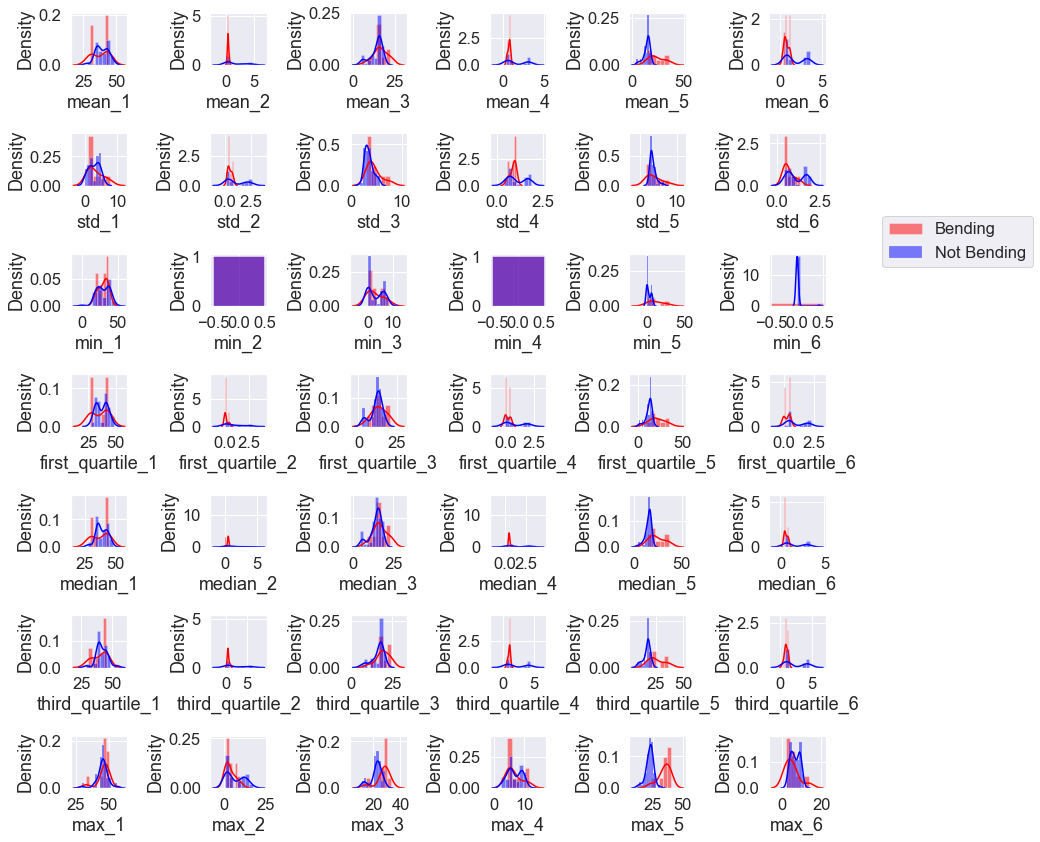

In [ ]:
# https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
# making plot for useful features as suggested on piazza
plt.figure(figsize=(12,12))
for i, ft in enumerate(features, start =1):
    for j in range(1,7):    
        plt.subplot(len(features), 6, 6*i+j-6)
        sns.histplot(bend_train.loc[bend_train['label']== 1][ft + str(j)] ,
                     kde = True,
                     color="red",
                     stat="density",
                     edgecolor=(1, 1, 1, .4),
                     kde_kws=dict(cut=3),
                     label="Bending")
        sns.histplot(bend_train.loc[bend_train['label']== 0][ft + str(j)], 
                     kde = True,
                     color="blue", 
                     stat="density",
                     kde_kws=dict(cut=3),
                     edgecolor=(1, 1, 1, .4),
                     label='Not Bending')
print("Different features analysis: ")
plt.tight_layout()
plt.legend(loc=(2,10))
plt.show()


I used plots to understand what features might be more useful. Not all features are equally important. Some are more significant than the others. Based on the results:
- Mean , max and third Quartile would would be useful according to me.
- Mean would give the avg val of the series, 
- max would give the peak val of the series and 
- third quartile would give the higher bound val of series.

### __ISLR 3.7.4__
__I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 + β1X + β2X2 + β3X3 + ε__

__(a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε . Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression.Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer__

Ans : The training RSS for Cubic regression would be lower than the training RSS for linear regression as it will fit more (overfit in this case) to the training data and have a lower bias

__(b) Answer (a) using test rather than training RSS.__

Ans : When using test RSS instead of training RSS Linear Regression would be better as true relationship between X and Y is linear, Cubic regression would have more error due to overfitting 

__(c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.__


Ans : Cubic regression would be better because it will have better flexibility (same as part (a))and more numbre of predictors than training RSS for linear regression .

__(d) Answer (c) using test rather than training RSS.__

Ans: There is not much information to tell. If the true relationship would have been linear , linear regression RSS would be lower for test data. If the relationship is far from linear the cubic regression RSS would be lower for testing data.

### __4. Binary Classification Using Logistic Regression__

#### __4(a)i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook)__

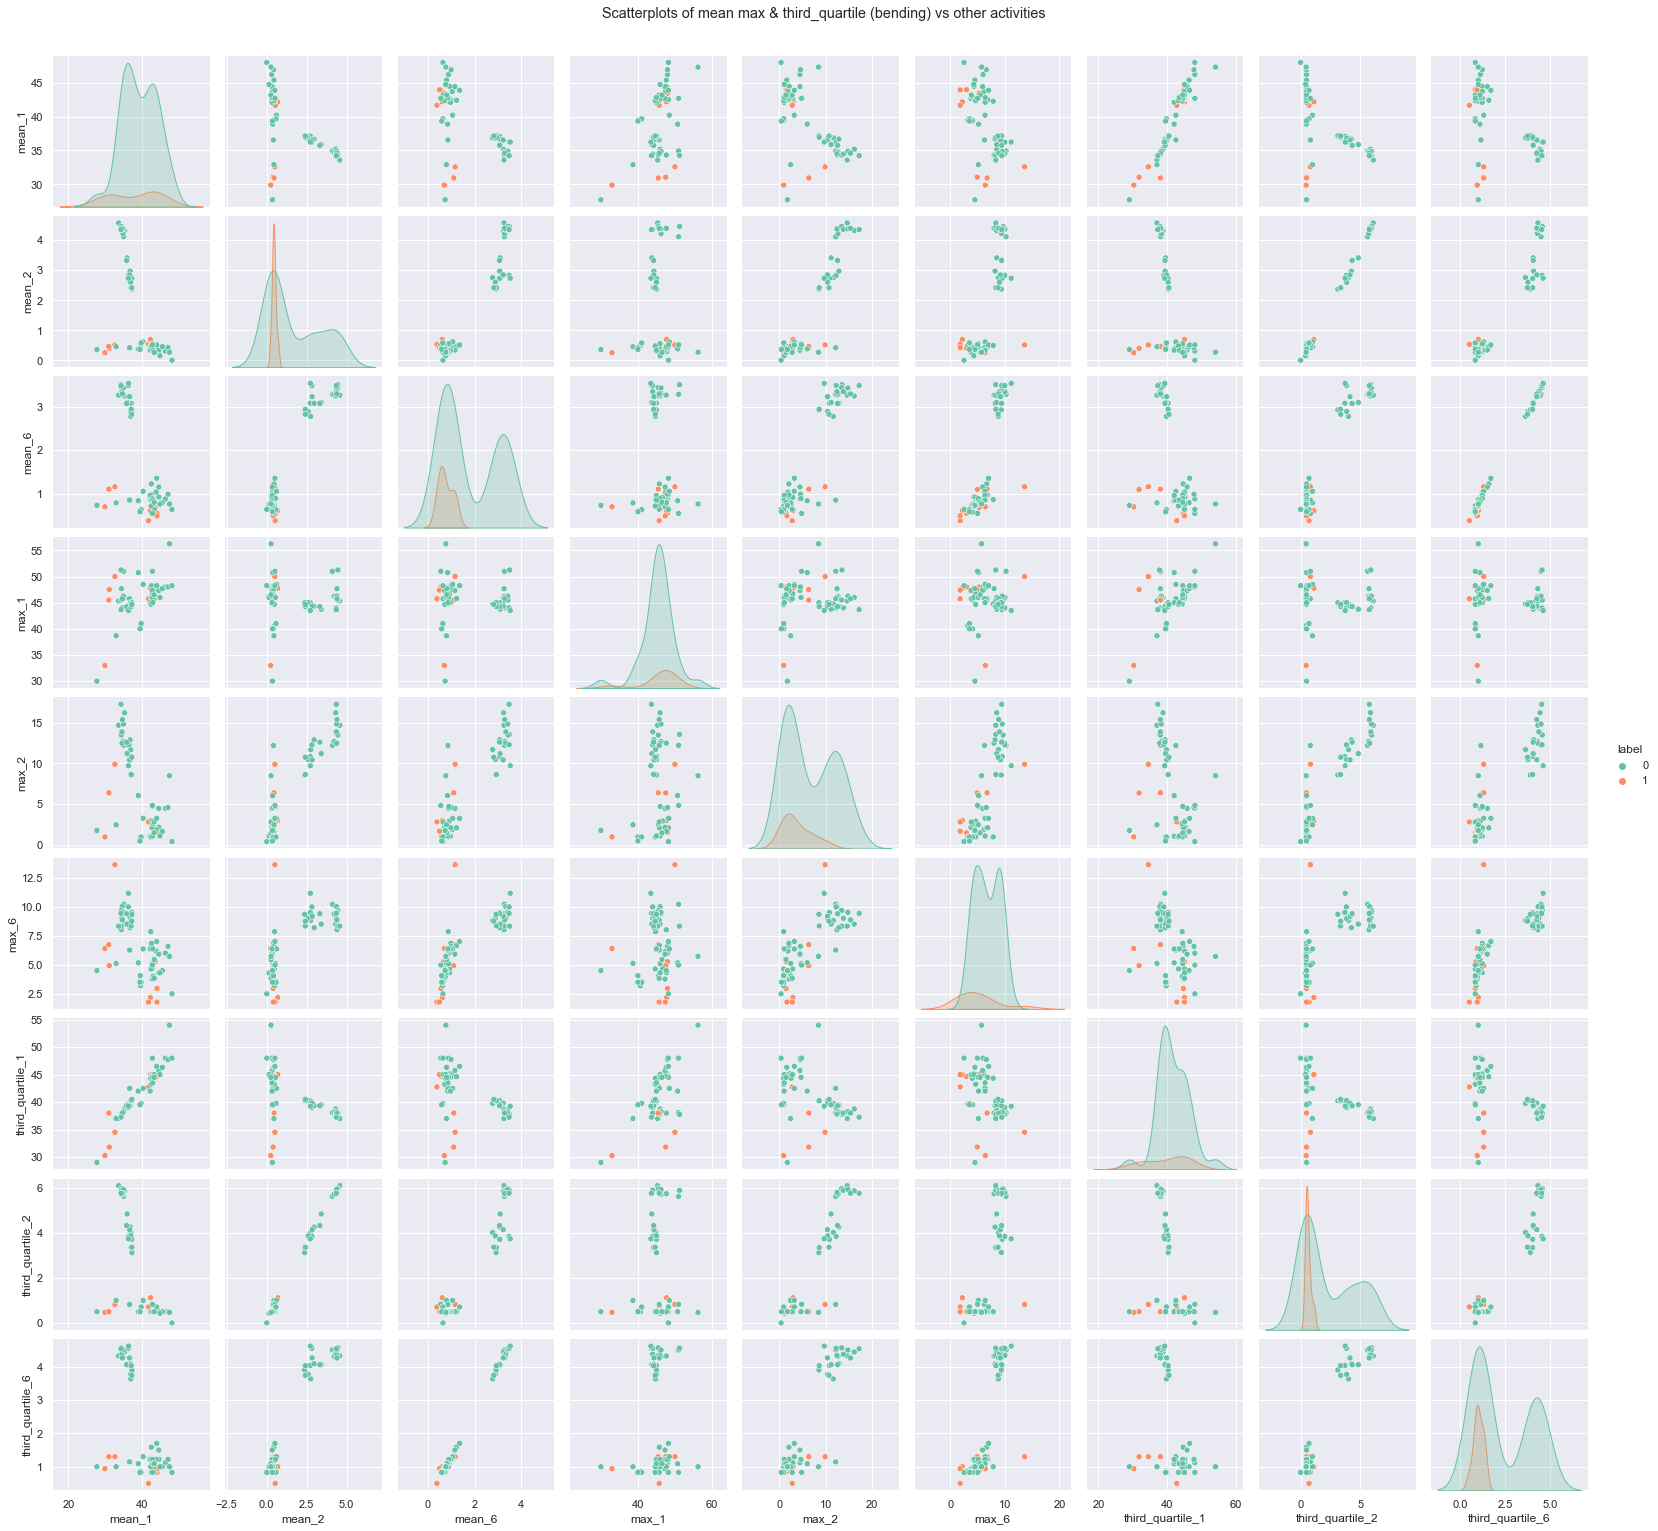

In [ ]:

series= [1,2,6]
stat = ["mean_","max_","third_quartile_"]

sel_features=[]
for i in stat:
    for j in series:
        sel_features.append(i+str(j))
scatter_df = bend_train[sel_features + ['label']]
# print(scatter_df)
sns.set(font_scale=1)
pairplot=sns.pairplot(scatter_df,hue='label', palette="Set2", kind='scatter')
plt.subplots_adjust(top=0.92)
pairplot.fig.suptitle("Scatterplots of mean max & third_quartile (bending) vs other activities", y=0.95)
# plt.legend(loc='center left')
plt.show()

#### __4(a)ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with those of 1(d)i?__

In [ ]:
# reorder the columns
update_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
new_col = ['min_','max_','mean_','median_','std_','first_quartile_', 'third_quartile_']
updated_feature = []
for j in range(len(update_columns)*2):
    for i in new_col:
        updated_feature.append(i+str(j+1))
train_metric = load_data(train_data, updated_feature, update_columns, split=2)
test_metric = load_data(test_set, updated_feature, update_columns, split=2)
sns.set(font_scale=1)

bend_train_metric = pd.DataFrame(train_metric)
bend_train_metric.loc[bend_train_metric['bending'].isin(['bending1', 'bending2']), 'bending'] = 1
new_dir = ['cycling', 'lying', 'sitting', 'standing', 'walking']
bend_train_metric.loc[bend_train_metric['bending'].isin(new_dir), 'bending'] = 0
bend_train_metric

ValueError: 516 columns passed, passed data had 84 columns

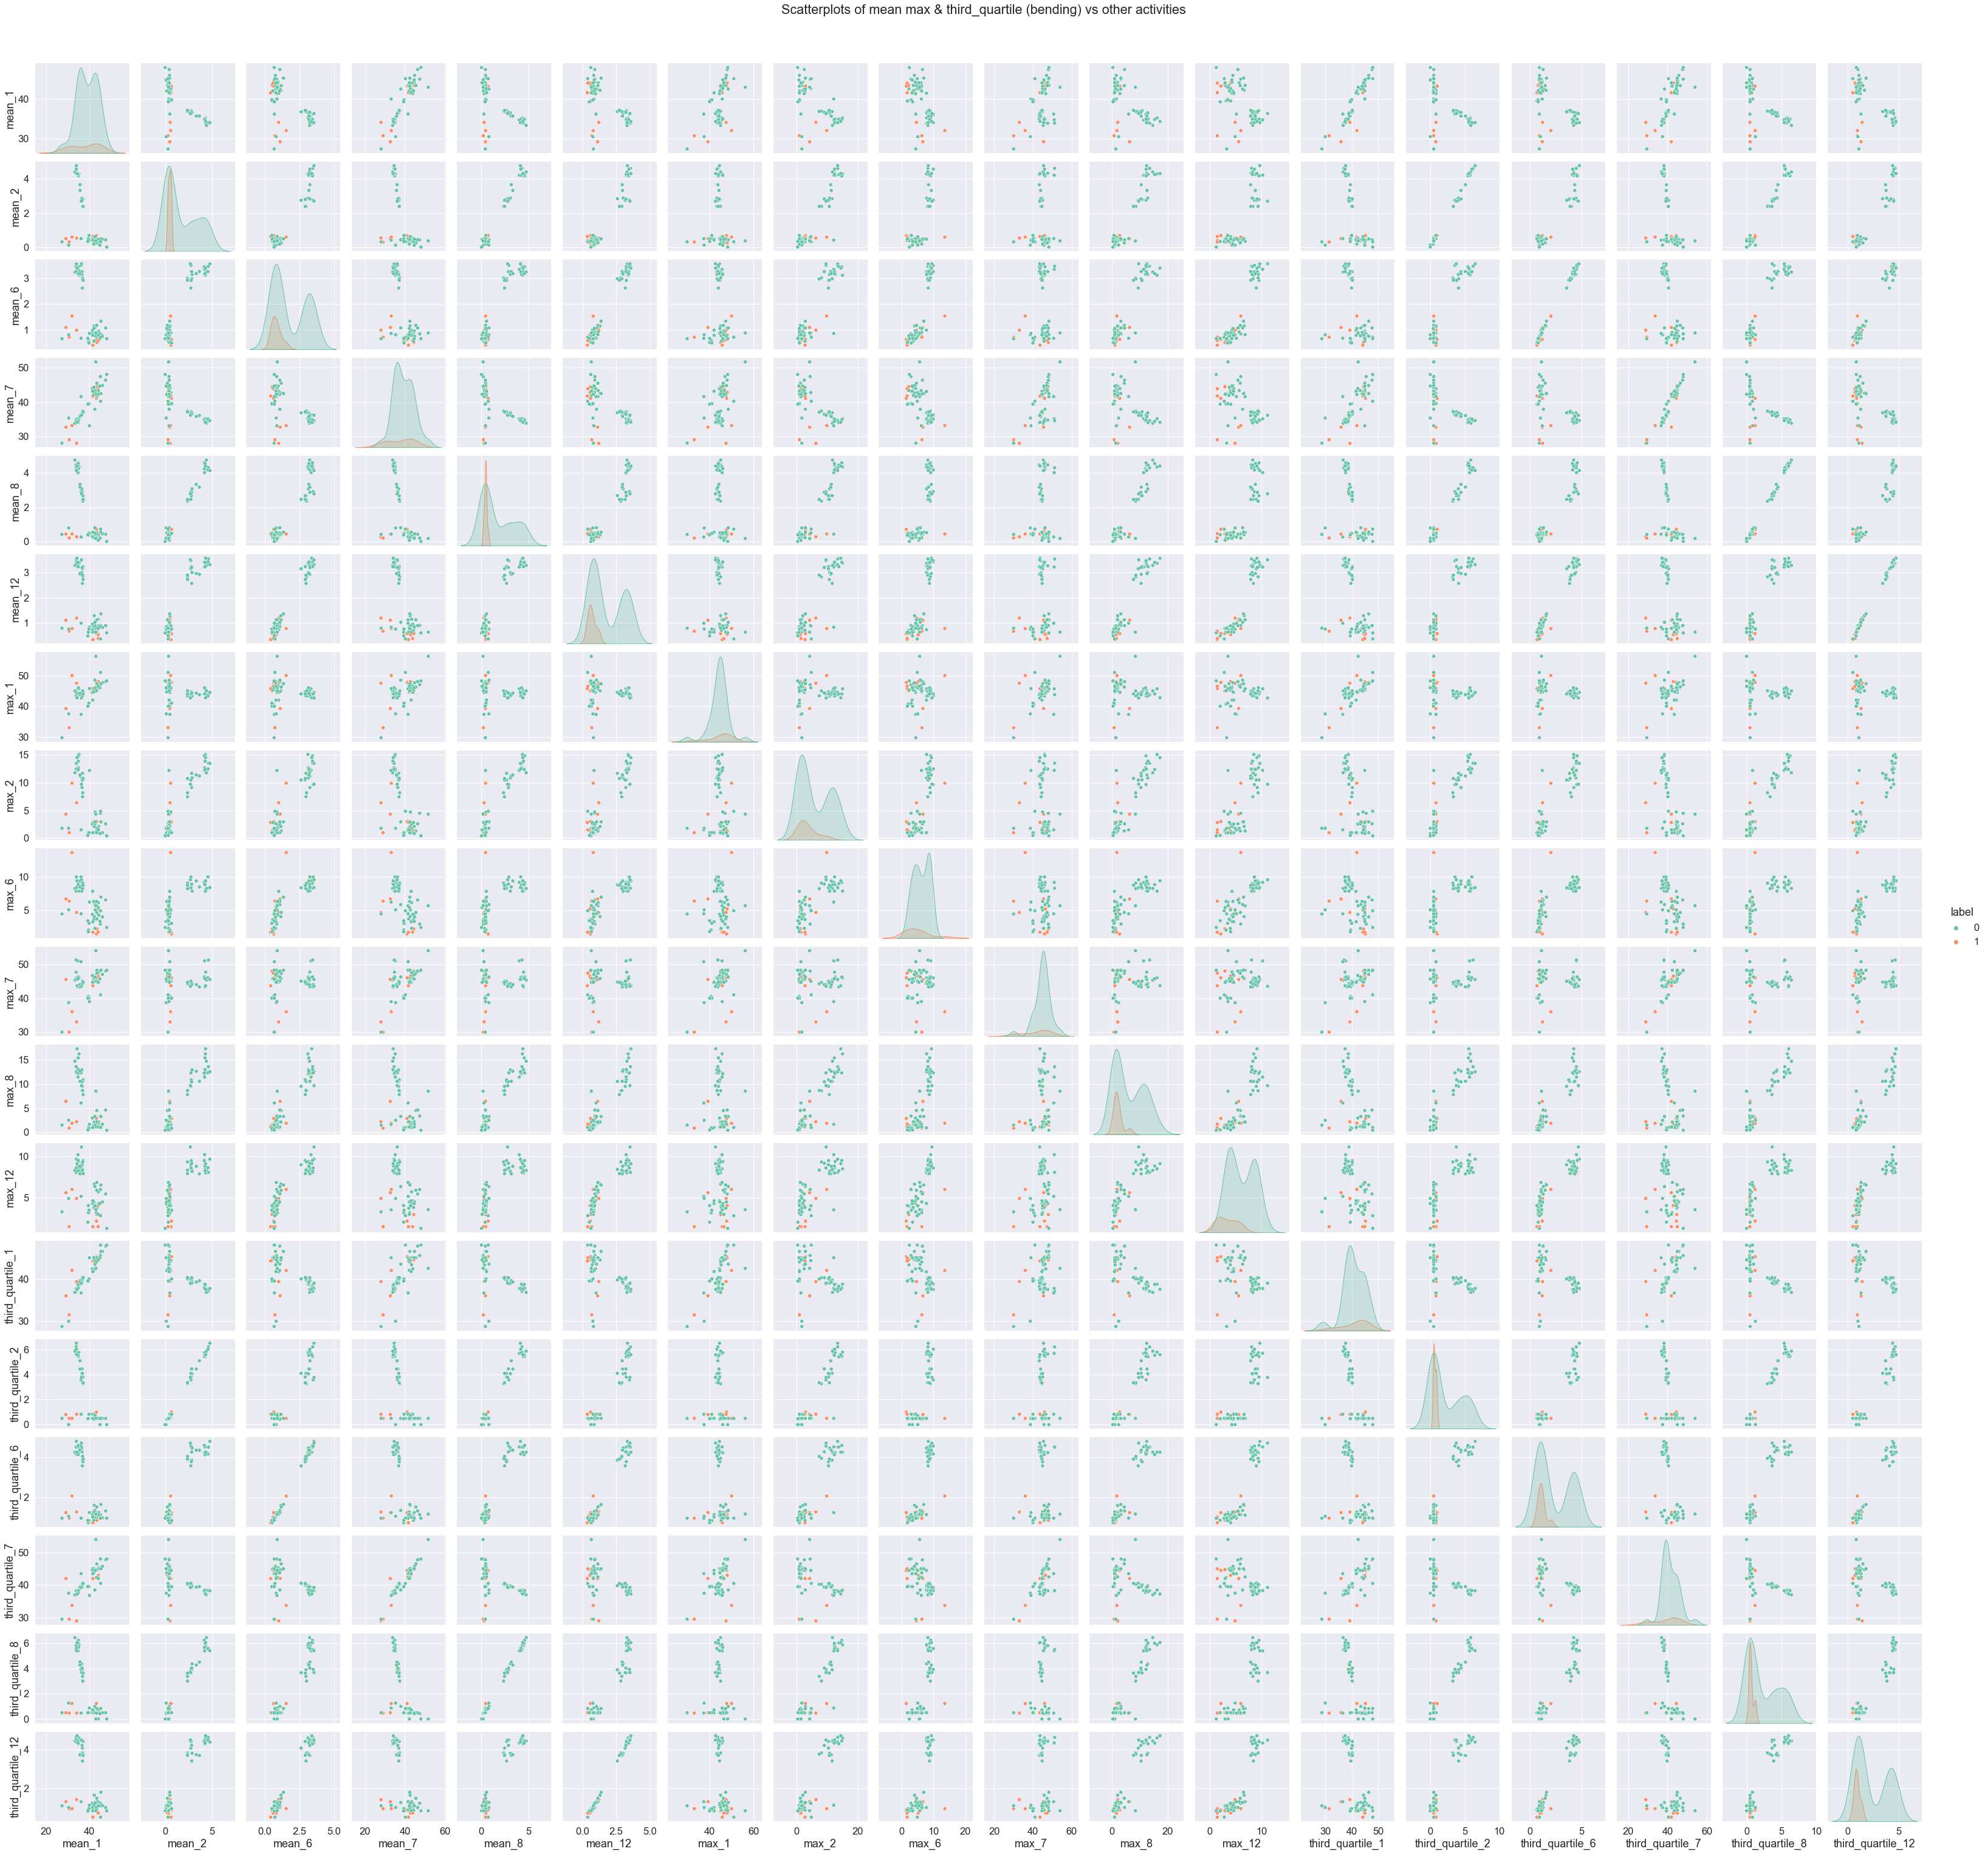

In [ ]:
series= [1,2,6,7,8,12]
stat = ["mean_","max_","third_quartile_"]

sel_features=[]
for i in stat:
    for j in series:
        sel_features.append(i+str(j))
sel_features = bend_train_metric[sel_features + ['label']]
sns.set(font_scale=1.5)
pairplot=sns.pairplot(sel_features,hue='label', palette="Set2", kind='scatter')
plt.subplots_adjust(top=0.92)
pairplot.fig.suptitle("Scatterplots of mean max & third_quartile (bending) vs other activities", y = 0.95)
plt.show()

For the second part of the question there is very slight difference between the two scatterplot distributions, the latter one (4ii) being more sparse than 4i but look very similar to the naked eye.

#### __4(a)iii Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance.Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair ( l, p ), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratifiedcross validation. Research what it means and use it if needed. In the following, you can see an example of applying Python’s Recursive Feature Elimination, which is a backward selection algorithm, to logistic regression__

In [ ]:
def downsampling(data):
    bending_1 = data.loc[data['bending'] == 1]
    bending_0 = data.loc[data['bending'] == 0]
        
    # Finding the min and max count of each label
    min_count = min(bending_1.shape[0], bending_0.shape[0])
    max_count = max(bending_1.shape[0], bending_0.shape[0])
        
    # Finding the major sample class
    max_bending = 1 if bending_1.shape[0] > bending_0.shape[0] else 0
        
    # Dividing into minor and major samples
    major_sample = data.loc[data['bending'] == max_bending]
    minor_sample = data.loc[data['bending'] != max_bending]
        
    # Resampling the major_sample
    major_sample = resample(major_sample, n_samples = min_count * 3, replace=True, random_state=7)
        
    data = pd.concat([minor_sample, major_sample], ignore_index=True)
    print(data)
    return data


In [ ]:
def logisticRegressionCV(train_data, k, L, overSample=False, penalty='none'):    
    feature_names_lcv = ['min_','max_','mean_','median_','std_','first_quartile_','third_quartile_']
    features_lcv = [name+str(i) for i in range(1,6*L+1) for name in feature_names_lcv]
    features_lcv.append('label')
    
    train_lcv = load_data(train_data, features_lcv, L)
    train_lcv['bending'] = [1 if data.find('bending') != -1 else 0 
                            for data in train_lcv['activity'].to_list()]
    train_lcv = train_lcv.drop(['label'], axis=1)
    
    #Using DownSampling technique
    if overSample:
        train_lcv = downsampling(train_lcv)
    
    feature_names_lcv_updated = ['max_','mean_','third_quartile_']
    features_lcv_updated = [name+str(i) for i in range(1,6*L+1) for name in feature_names_lcv_updated]
    features_lcv_updated.append('bending')
    
    train_lcv = train_lcv[features_lcv_updated]
    
    train_lcv_X = train_lcv.iloc[:,:-1]
    train_lcv_Y = train_lcv.iloc[:,-1]
    
    stratified_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=7)
    lr_model = LogisticRegression(penalty=penalty, solver='lbfgs')
    feature_selector = RFECV(estimator=lr_model, cv=stratified_cv)
    feature_selector.fit(train_lcv_X, train_lcv_Y)
    
    return feature_selector, lr_model

In [ ]:
def get_selected_features(lcv_result, overSample=False):
    # Best L
    best_pair = lcv_result.loc[lcv_result['score'] == max(lcv_result['score'])]
    best_L = best_pair['L'].to_list()[0]
    
    # Feature names for best L
    feature_names_best_lcv = ['max_','mean_','third_quartile_']
    features_best_lcv = [name+str(i) for i in range(1,6*best_L+1) for name in feature_names_best_lcv]

    # Selected features for best L
    feature_selector, lr_model = logisticRegressionCV(train_data, 5, best_L, overSample=overSample)
    selected_features = [f for i, f in enumerate(features_best_lcv) if feature_selector.support_[i]]
    
    if overSample:
        eature_names = ['min_','max_','mean_','median_','std_','first_quartile_','third_quartile_']
        features_load = [name+str(i) for i in range(1,6*best_L+1) for name in columns]
        features_load.append('activity')
        data_lcv = load_data(train_data, features_load, best_L)
        data_lcv['bending'] = [1 if data.find('bending') != -1 else 0 
                            for data in data_lcv['activity'].to_list()]
        data_lcv = data_lcv.drop(['activity'], axis=1)
        
        bending_1 = data_lcv.loc[data_lcv['bending'] == 1]
        bending_0 = data_lcv.loc[data_lcv['bending'] == 0]
        
        pi = bending_1.shape[0] / (bending_1.shape[0] + bending_0.shape[0])
        pi1 = 1 / 4
        feature_selector.estimator_.intercept_ += pi/(1-pi) + pi1/(1-pi1)

    return selected_features, best_L, lr_model 

In [ ]:
def get_data_splits(data, best_L, overSample=False):
    feature_names = ['min_','max_','mean_','median_','std_','first_quartile_','third_quartile_']
    features_load = [name+str(i) for i in range(1,6*best_L+1) for name in feature_names]
    features_load.append('activity')
    
    data_lcv = load_data(data, features_load, best_L)
    data_lcv['bending'] = [1 if data.find('bending') != -1 else 0 
                            for data in data_lcv['activity'].to_list()]
    data_lcv = data_lcv.drop(['activity'], axis=1)
    
    if overSample:
        data_lcv = downsampling(data_lcv)
    
    data_lcv_X = data_lcv.iloc[:,:-1]
    data_lcv_X = data_lcv_X[selected_features]
    data_lcv_Y = data_lcv.iloc[:,-1]
    
    return data_lcv_X, data_lcv_Y

In [ ]:
def c_matrix(lr_model, data_X, data_Y):
    lr_model.fit(data_X, data_Y)
    predict_Y = lr_model.predict(data_X)
    matrix = confusion_matrix(data_Y, predict_Y)
    return matrix

In [ ]:
def roc_auc(data_X, data_Y, lr_model, data_type):
    #ROC and AUC
    predict_Y_prob_estimates = lr_model.predict_proba(data_X)
    
    #predictY_prob_estimates[:, 1] - indicates getting the positive label estimates
    fpr, tpr, thresholds = roc_curve(data_Y, predict_Y_prob_estimates[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    plt.close()
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, 'b', label="Area Under Curve(AUC): {}".format(roc_auc))
    plt.plot([0,1], [0,1], 'k--')

    plt.title('ROC Curve for {} data'.format(data_type))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
from tqdm import tqdm

lcv_result = pd.DataFrame(columns=['L', 'p','score'])

for i in tqdm(range(1,21)):
    lst=[]
    features_selected, lr_model = logisticRegressionCV(train_data, 5, i)
    lst.extend([i, features_selected.n_features_, max(features_selected.cv_results_["mean_test_score"])])
    lst_data = pd.Series(lst, index = ['L', 'p', 'score'])
    lcv_result = lcv_result.append(lst_data, ignore_index=True)
    lcv_result['L'] = lcv_result['L'].astype(int)
    lcv_result['p'] = lcv_result['p'].astype(int)

lcv_result

  0%|          | 0/20 [00:01<?, ?it/s]


KeyError: "['activity'] not in index"

In [ ]:
# import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# perform logistic regression and cross validation for a given value of l
# k is number of folds
def logisticRegressionCV(train_data, test_set, k, l, penalty, oversample):
    # specify columns
    feature = []
    orig_columns = [ 
                    'avg_rss12', 'var_rss12', 
                    'avg_rss13', 'var_rss13', 
                    'avg_rss23', 'var_rss23']
    
    new_col = ['max_','mean_','third_quartile_']
    feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in new_col]
    
    # for i in orig_columns:
    #     for j in new_col:
    #         feature.append(i+str(j+1))
            
    
    # load data with given value of l
    training_set = load_data(train_data, feature, orig_columns, split=l)
    training_set.loc[training_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
    training_set.loc[training_set['label'] != "1", 'label'] = "0"
    #print(training_set)
    #test_set = load_data(test_set, feature, orig_columns, split=l)
    
    # oversample the data if required
    if oversample:
        num_label_0 = training_set.loc[training_set['label'] == "0"].shape[0]
        num_label_1 = training_set.loc[training_set['label'] == "1"].shape[0]
        minor_count = min(num_label_0, num_label_1)
        major_count = max(num_label_0, num_label_1)
        minor_label = "1" if num_label_0 > num_label_1 else "0"
        minor = training_set.loc[training_set['label'] == minor_label]
        major = training_set.loc[training_set['label'] != minor_label]
        minor = resample(minor, replace=True, random_state=42,
                         n_samples=max(num_label_0, num_label_1))
        training_set = pd.concat([major, minor])
        print("Oversample the minority from {} to {} samples".format(minor_count, 
                                                                     major_count))
    
    # split features and labels
    trainX, trainY = training_set.iloc[:, :-1], training_set.iloc[:, -1]
    #print(trainX.shape)
    #testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
    
    # create 5-fold cross validator, logistic regression classifier and featrue selector
    if penalty == 'l1':
        solver = 'liblinear'
    else:
        solver = 'lbfgs'
    validator = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    selector.fit(trainX, trainY)
    
    # return the feature selector
    return model, selector

# interate values of l from 1 to 20
def iterateL(train_data, test_set, k, L, penalty='none', oversample=False):
    best_p = []
    score = []
    
    for l in range(1, L + 1):
        classifier, selector = logisticRegressionCV(train_data, test_set, 
                                                    k, l, penalty=penalty,
                                                    oversample=oversample)
        best_p.append(selector.n_features_)
        # score.append(selector.cv_results_['split1_test_score'])
        score.append(selector.cv_results_['mean_test_score'])
        # print(score)
        #print(selector.support_)
        # print("Pair {}, scores {}".format((l, best_p[-1]), 
        #                                   round(max(selector.grid_scores_), 4)))
        print("Pair:(",str(l)+","+str(selector.n_features_)+")", "Scores:", max(selector.cv_results_['mean_test_score']))
        # print("Pair:(",str(i)+","+str(selector.n_features_)+")", "Scores:", max(selector.grid_scores_))

In [ ]:
iterateL(train_data, test_set, 5, 20)

Pair:( 1,5) Scores: 0.9857142857142858
Pair:( 2,13) Scores: 0.9857142857142858
Pair:( 3,1) Scores: 0.9714285714285715
Pair:( 4,11) Scores: 0.9857142857142858
Pair:( 5,9) Scores: 0.9857142857142858
Pair:( 6,17) Scores: 0.9857142857142858
Pair:( 7,15) Scores: 0.9857142857142858
Pair:( 8,13) Scores: 0.9857142857142858
Pair:( 9,22) Scores: 0.9857142857142858
Pair:( 10,30) Scores: 0.9857142857142858
Pair:( 11,26) Scores: 0.9857142857142858
Pair:( 12,16) Scores: 0.9857142857142858
Pair:( 13,96) Scores: 0.9857142857142858
Pair:( 14,60) Scores: 0.9857142857142858
Pair:( 15,32) Scores: 0.9857142857142858
Pair:( 16,10) Scores: 0.9857142857142858
Pair:( 17,35) Scores: 0.9857142857142858
Pair:( 18,41) Scores: 0.9857142857142858
Pair:( 19,101) Scores: 0.9857142857142858
Pair:( 20,69) Scores: 0.9857142857142858


#### __4. a(iv). Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.__

In [ ]:
"""
Doc Refrence:
1. LogisticRegressionCV: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV.score
"""

# fit model with l = 1
statistics = ['max_','mean_','third_quartile_']
feature = [stat + str(i) for i in range(1, 6 * 1 + 1) for stat in statistics]

# get the selected feature
classifier, selector = logisticRegressionCV(train_data, test_set, 5, 1, 
                                            penalty='none', oversample=False)
selected_feature = [f for i, f in enumerate(feature) if selector.support_[i]]

selected_feature

['third_quartile_1', 'third_quartile_3', 'max_5', 'mean_5', 'max_6']

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

train_data = load_data(train_data, feature, columns, split=1)
train_data.loc[train_data['label'].isin(['bending1', 'bending2']), 'label'] = 1
train_data.loc[train_data['label'] != 1, 'label'] = 0
trainX, trainY = train_data.iloc[:, :-1], train_data.iloc[:, -1]

# build model, remember to add constant to features
trainX_const = sm.add_constant(trainX.loc[:, selected_feature].to_numpy(dtype=float))
#print(trainY.to_numpy())
model = sm.Logit(trainY.to_numpy(dtype=float), trainX_const)
#logitres = model.fit_regularized()
logitres = model.fit(method='bfgs')

print(logitres.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       63
Method:                           MLE   Df Model:                            5
Date:                Wed, 12 Oct 2022   Pseudo R-squ.:                   1.000
Time:                        18:29:13   Log-Likelihood:            -1.1180e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.738e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6433    2.6e+05  -2.4

[[60  0]
 [ 0  9]]


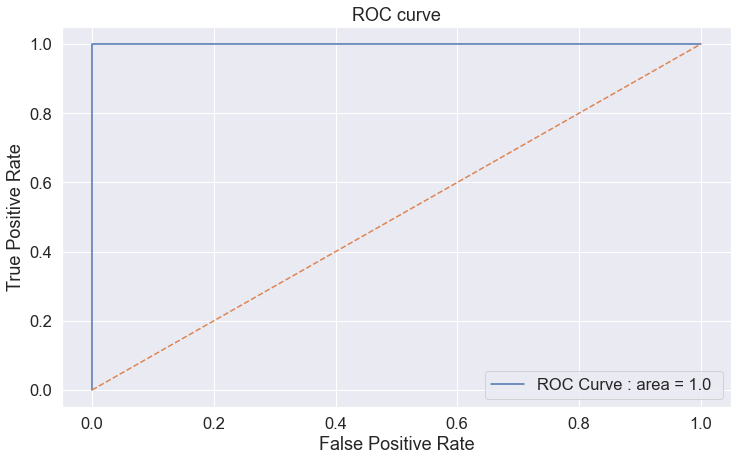

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# predictY = logitres.predict(trainX_const)
# fpr, tpr, thresholds = roc_curve(trainY.to_numpy(dtype=float), predictY, pos_label=1)
# print(trainY.to_numpy(dtype=float))
# print(type(predictY[0]))

classifier.fit(trainX.loc[:, selected_feature], trainY.to_numpy(dtype="int"))
predictY = classifier.predict(trainX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(trainX.loc[:, selected_feature])

fpr, tpr, thresholds = roc_curve(trainY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

conf_mat = confusion_matrix(trainY.to_numpy(dtype=float), predictY.round())
print(conf_mat)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

#### __v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.__

In [ ]:

test_set = load_data(test_set, feature, columns, split=1)
test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
test_set.loc[test_set['label'] != 1, 'label'] = 0
testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]

# predictY = logitres.predict(testX_const)
# testX_const = sm.add_constant(testX.loc[:, selected_feature].to_numpy(dtype=float))

# make predict use the model kept by RFECV
predictY = classifier.predict(testX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(testX.loc[:, selected_feature])

fpr, tpr, thresholds = roc_curve(testY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

# create confusion matrix
conf_mat = confusion_matrix(testY.astype(int), predictY.astype(int))
print(conf_mat)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
print(roc_auc)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'max_1'

### __4a.(d)-vi Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?__


Yes. The summary of statmodels has following statement

Complete Separation: The results show that there is complete separation. In this case the Maximum Likelihood Estimator does not exist and the parameters are not identified.

### __1.(d)-vii From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.__

In [ ]:
iterateL(train_data, test_set, 5, 20, oversample=True)

FileNotFoundError: [Errno 2] No such file or directory: 'max_1'

In [ ]:
# fit model with l = 1
statistics = ['max_','mean_', 'third_quartile_']
feature = [stat + str(i) for i in range(1, 6 * 1 + 1) for stat in statistics]

# get the selected feature
classifier, selector = logisticRegressionCV(train_data, test_set, 5, 1, 
                                            penalty='none', oversample=True)
selected_feature = [f for i, f in enumerate(feature) if selector.support_[i]]

selected_feature

FileNotFoundError: [Errno 2] No such file or directory: 'max_1'

In [ ]:
# load original data
train_data = load_data(train_data, feature, columns, segs=1)
train_data.loc[train_data['label'].isin(['bending1', 'bending2']), 'label'] = 1
train_data.loc[train_data['label'] != 1, 'label'] = 0

# oversample
num_label_0 = train_data.loc[train_data['label'] == 0].shape[0]
num_label_1 = train_data.loc[train_data['label'] == 1].shape[0]
minor_count = min(num_label_0, num_label_1)
major_count = max(num_label_0, num_label_1)
minor_label = 1 if num_label_0 > num_label_1 else 0
minor = train_data.loc[train_data['label'] == minor_label]
major = train_data.loc[train_data['label'] != minor_label]
minor = resample(minor, replace=True, 
                         n_samples=max(num_label_0, num_label_1))
train_data = pd.concat([major, minor])
print("Oversample the minority from {} to {} samples".format(minor_count, 
                                                            major_count))

trainX, trainY = train_data.iloc[:, :-1], train_data.iloc[:, -1]

classifier.fit(trainX.loc[:, selected_feature], trainY.to_numpy(dtype="int"))
predictY = classifier.predict(trainX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(trainX.loc[:, selected_feature])

fpr, tpr, thresholds = roc_curve(trainY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

conf_mat = confusion_matrix(trainY.to_numpy(dtype=float), predictY.round())
print(conf_mat)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

In [ ]:
test_set = load_data(test_set, feature, columns, segs=1)
test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
test_set.loc[test_set['label'] != 1, 'label'] = 0
testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]

# make predict use the model kept by RFECV
predictY = classifier.predict(testX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(testX.loc[:, selected_feature])

# create confusion matrix
conf_mat = confusion_matrix(testY.astype(int), predictY.astype(int))
print(conf_mat)

# plot ROC curve for test set
fpr, tpr, thresholds = roc_curve(testY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()


### __(b) Binary Classification Using L1-penalized logistic regression__


### __1.(e)-i. Repeat 1(d)iii using L1-penalized logistic regression,8 i.e. instead of using p-values for variable selection, use L1 regularization.__

In [ ]:
# function to perform cross validation and find optimal l 
# with given classifier and specified paramter settings
def iterateLWithClf(classifier_obj, kwargs, binary_classes):
    for l in range(1, 20 + 1):
        # specify columns
        orig_columns = ['# Columns: time', 
                        'avg_rss12', 'var_rss12', 
                        'avg_rss13', 'var_rss13', 
                        'avg_rss23', 'var_rss23']
        
        statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
        feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in statistics]
        
        # load data with given value of l
        train_data = load_data(train_files, feature, orig_columns, segs=l)
        test_set = load_data(test_files, feature, orig_columns, segs=l)
        
        # relabel the instance if it is binary classification
        if binary_classes:
            train_data.loc[train_data['label'].isin(['bending1', 'bending2']), 'label'] = "1"
            train_data.loc[train_data['label'] != "1", 'label'] = "0"
            test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
            test_set.loc[test_set['label'] != "1", 'label'] = "0"
        
        # split feature and label
        trainX, trainY = train_data.iloc[:, :-1], train_data.iloc[:, -1]
        testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
        
        # build the classifier and fit the data
        classifier = classifier_obj(**kwargs)
        classifier.fit(trainX, trainY)
        
        # calculate the scores
        train_score = classifier.score(trainX, trainY)
        test_score = classifier.score(testX, testY)
        
        print("Value of l ~ {} : train scores {}, test score {}".format(l, 
                                                     round(train_score, 4), 
                                                     round(test_score, 4)))

        